In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

Exceptions were found
[AssertionError('Non singular values found'), AssertionError('Non singular values found'), AssertionError('Non singular values found')]


In [5]:
df_all

,date,sp_Open,sp_High,sp_Low,sp_close,sp_adj_close,sp_volume,vixo,vixh,vixl,...,sp_close_lead2,sp_close_lead1,sp_close_lead0,sp_close_lag1,sp_close_lag2,sp_close_lag3,sp_close_lag4,sp_close_lag5,sp_close_lag6,sp_close_lag7
0,1990-01-02,353.40,359.69,351.98,359.69,359.69,1.620700e+08,17.24,17.24,17.24,...,355.67,358.76,359.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-03,359.69,360.59,357.89,358.76,358.76,1.923300e+08,18.19,18.19,18.19,...,352.20,355.67,358.76,359.69,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-01-04,358.76,358.76,352.89,355.67,355.67,1.770000e+08,19.22,19.22,19.22,...,353.79,352.20,355.67,358.76,359.69,NaN,NaN,NaN,NaN,NaN
3,1990-01-05,355.67,355.67,351.35,352.20,352.20,1.585300e+08,20.11,20.11,20.11,...,349.62,353.79,352.20,355.67,358.76,359.69,NaN,NaN,NaN,NaN
4,1990-01-08,352.20,354.24,350.54,353.79,353.79,1.401100e+08,20.26,20.26,20.26,...,347.31,349.62,353.79,352.20,355.67,358.76,359.69,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8058,2021-12-23,4703.96,4740.74,4703.96,4725.79,4725.79,2.194630e+09,NaN,NaN,NaN,...,4786.35,4791.19,4725.79,4696.56,4649.23,4568.02,4620.64,4668.67,4709.85,4634.09
8059,2021-12-27,4733.99,4791.49,4733.99,4791.19,4791.19,2.264120e+09,NaN,NaN,NaN,...,4793.06,4786.35,4791.19,4725.79,4696.56,4649.23,4568.02,4620.64,4668.67,4709.85
8060,2021-12-28,4795.49,4807.02,4780.04,4786.35,4786.35,2.217050e+09,NaN,NaN,NaN,...,4778.73,4793.06,4786.35,4791.19,4725.79,4696.56,4649.23,4568.02,4620.64,4668.67
8061,2021-12-29,4788.64,4804.06,4778.08,4793.06,4793.06,2.369370e+09,NaN,NaN,NaN,...,NaN,4778.73,4793.06,4786.35,4791.19,4725.79,4696.56,4649.23,4568.02,4620.64


In [38]:
df_all["is_monday"] = df_all.date.apply(lambda x: x.weekday() == 0)

In [45]:
df_all[["date", "is_monday", "fears35"]].dropna()

,date,is_monday,fears35
3656,2004-07-01,False,-0.218879
3657,2004-07-02,False,-0.378581
3658,2004-07-06,False,0.421106
3659,2004-07-07,False,0.821884
3660,2004-07-08,False,-0.275630
...,...,...,...
5542,2011-12-23,False,-0.314051
5543,2011-12-27,False,1.053921
5544,2011-12-28,False,0.351728
5545,2011-12-29,False,0.302503


In [6]:
# select relevant data
df_w = df_all.copy()

## SELECT COLS INCLUDED HERE
drop_cols = data_dict["data_cols"]["fears"] + data_dict["data_cols"]["goog_sent"] + data_dict["data_cols"]["put_call"] + data_dict["data_cols"]["naaim_risk"]
df_w = df_w.drop(drop_cols, axis=1).copy()

# get data on weekly basis
df_w = cut_to_weekly_data(df_w).reset_index(drop=True)

# get lead variable as target
# get lag variable as X
df_w = shift_var_relative_to_df(df_w, shift_var=["sp_close", "sp_close", "sp_close", "sp_close", "sp_close"],
                                new_var_name=["sp_close_lead1", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_close_lag4"],
                                no_lags=[-1, 1, 2, 3, 4])

# preserve actual prices
df_w["sp_true_vals"] = df_w["sp_close"]

In [7]:
# get aggregation variables
df_w["sp_agg1"] = df_w.sp_close_lag1 * df_w.sp_close_lag2 * df_w.sp_close_lag3 * df_w.sp_close_lag4

In [8]:
# edit data_dict
# predicted is y col
data_dict.update(predicted="sp_close_lead1")
# actual sp prices
data_dict.update(sp_true_vals="sp_true_vals")
# all sp cols, lags & leads
data_dict.update(sp_cols=["sp_close", "sp_close_lead1", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_close_lag4", "sp_agg1"])


relevant_cols=[
    # 'fears35',
    # 'fears25',
    # 'fears30',
    'vixo',
    # 'naaim_ind',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    'termspread',
    # 'pc_ratio',
    'aaii_Bullish',
    # 'goog_sent'
] 

# relevant cols are features + sp_cols + target col, thus all relevant columns
relevant_cols = relevant_cols + data_dict["sp_cols"]

data_dict.update(relevant_cols=relevant_cols)

# predictors are all X cols
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [9]:
# sanity check
_ = [item for item in data_dict["relevant_cols"] if item not in df_w.columns]
assert len(_) == 0, f"Relevant cols has columns not pertaining to df: {_}"

In [14]:
# log returns
# all cols but ff_factors, as these are returns already
df_w, dist, log = df_log_return(df_w,
                                cols=[item for item in data_dict["relevant_cols"] if item not in data_dict["data_cols"]["ff_factors5"]])

data_dict = update_dict(data_dict,
            update_keys=["dist_translation", "log_return"],
            update_vals=[dist, log])

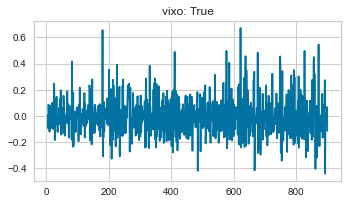

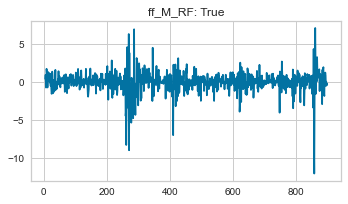

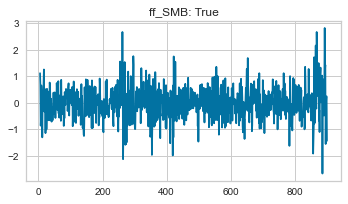

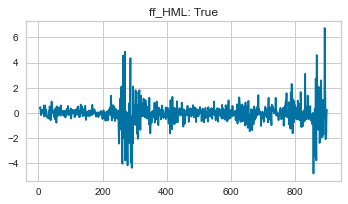

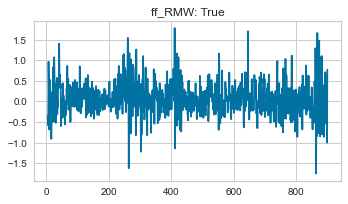

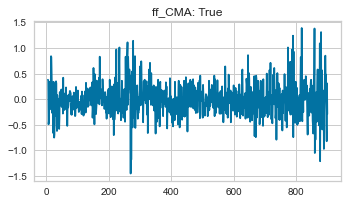

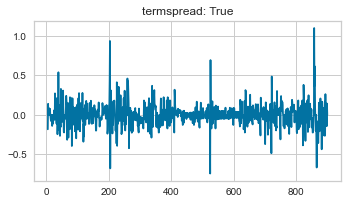

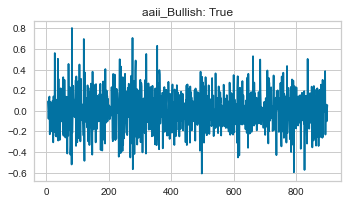

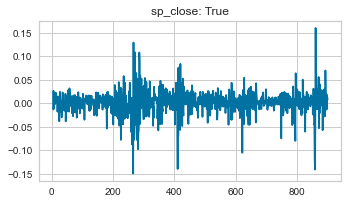

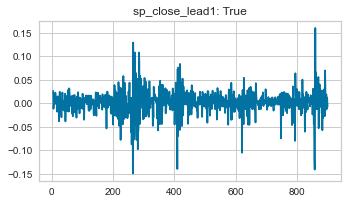

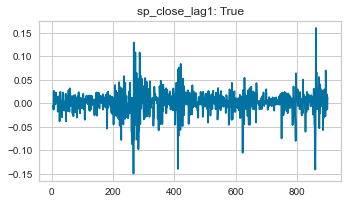

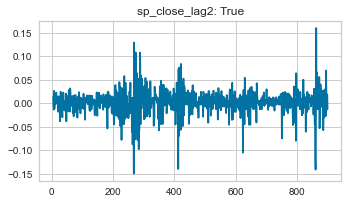

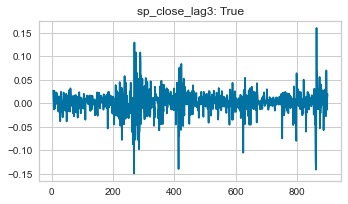

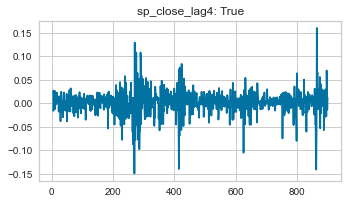

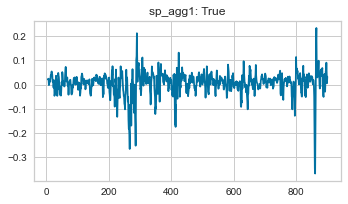

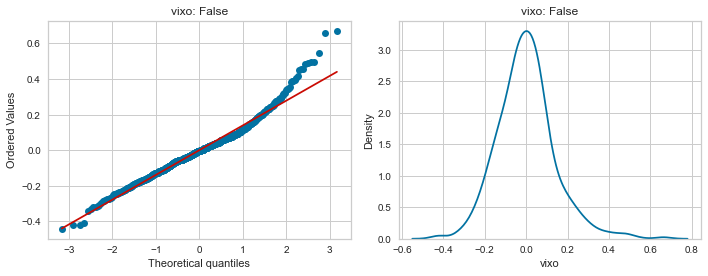

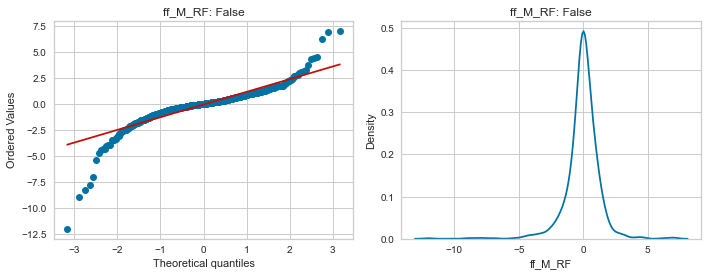

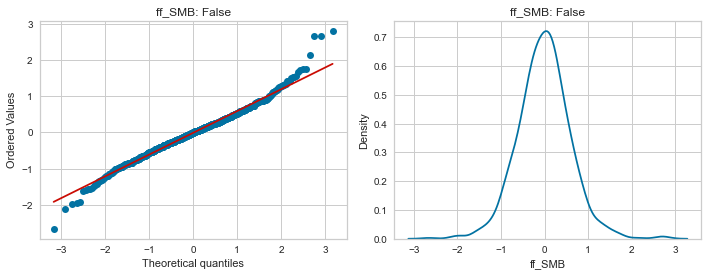

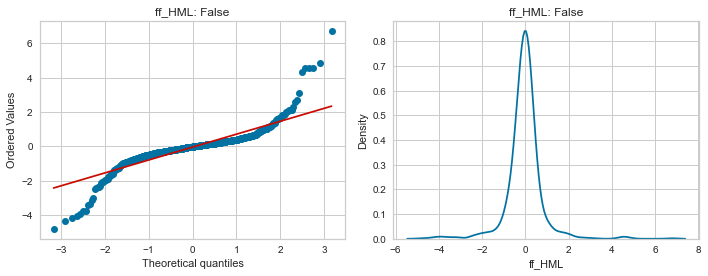

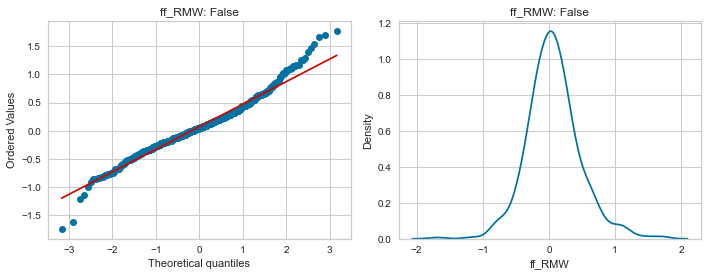

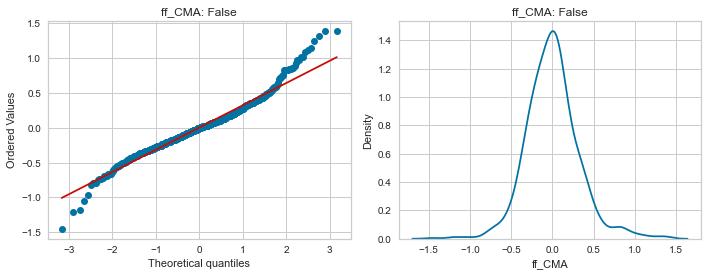

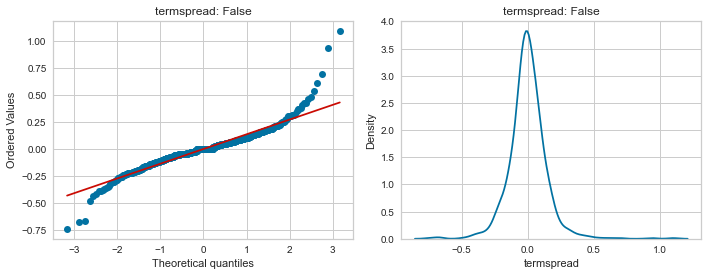

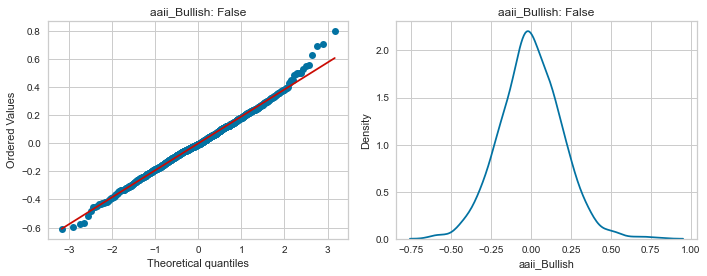

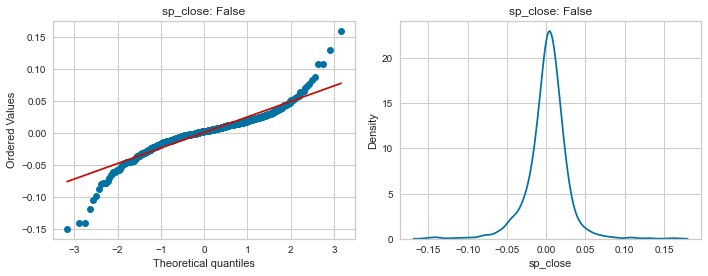

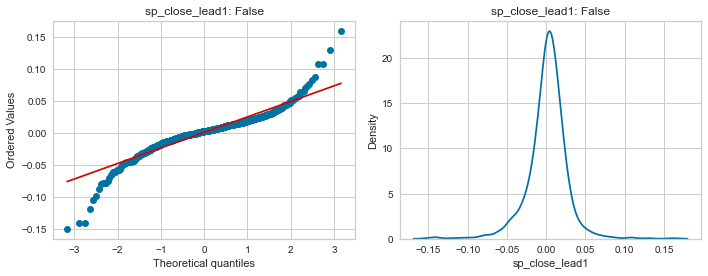

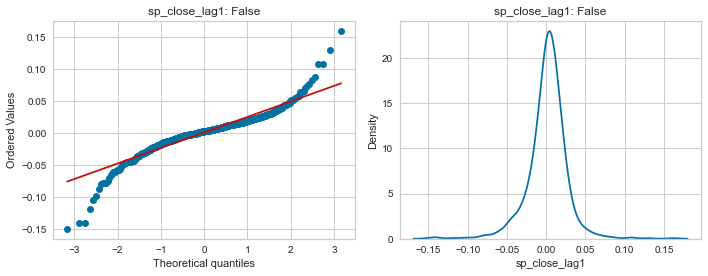

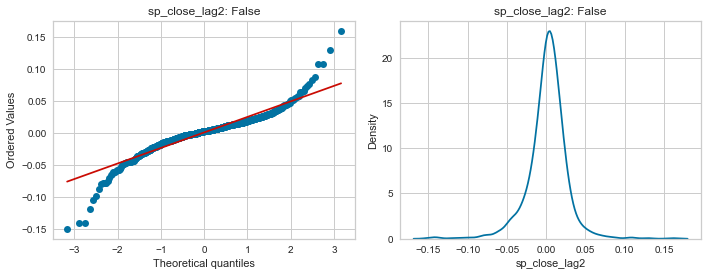

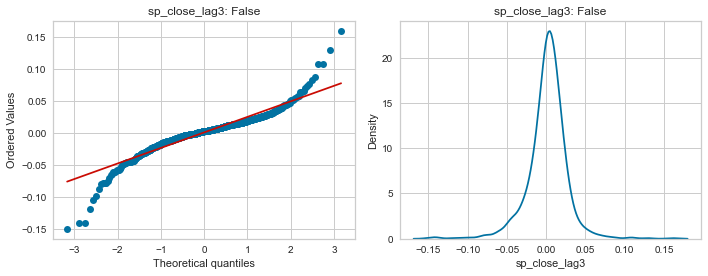

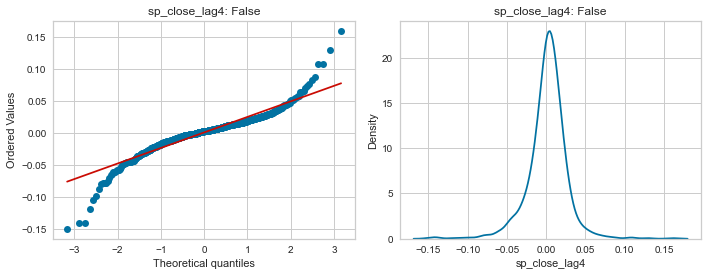

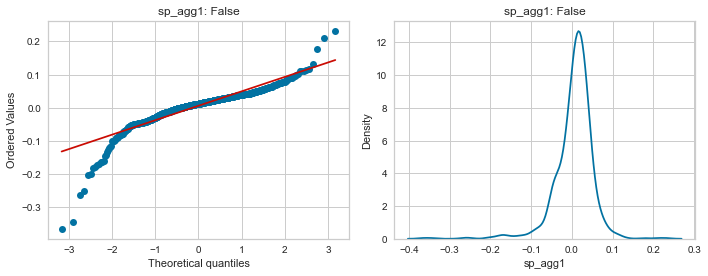

{'vixo': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'aaii_Bullish': True,
 'sp_close': True,
 'sp_close_lead1': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True,
 'sp_close_lag4': True,
 'sp_agg1': True}

In [15]:
# test normality & stationarity
stest = StatsTest(plot=True)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
data_dict.update(normality=normality)

stationarity

# Saving

In [16]:
df_w.head()

,date,sp_Open,sp_High,sp_Low,sp_close,sp_adj_close,sp_volume,vixo,vixh,vixl,...,aaii_Bullish Average,aaii_Bullish Average +St. Dev.,aaii_Bullish Average - St. Dev.,sp_close_lead1,sp_close_lag1,sp_close_lag2,sp_close_lag3,sp_close_lag4,sp_true_vals,sp_agg1
5,2003-10-27,1028.91,1037.75,1028.91,-0.013055,1031.13,1.371800e+09,0.007261,18.18,17.74,...,0.379967,0.480016,0.279917,0.026689,-0.004584,0.014522,0.027215,-0.016005,1031.13,0.021147
6,2003-11-03,1050.71,1061.44,1050.71,0.026689,1059.02,1.378200e+09,-0.095700,16.70,16.22,...,0.379967,0.480016,0.279917,-0.011310,-0.013055,-0.004584,0.014522,0.027215,1059.02,0.024097
7,2003-11-10,1053.21,1053.65,1045.58,-0.011310,1047.11,1.243600e+09,0.085633,17.88,17.53,...,0.379967,0.480016,0.279917,-0.003329,0.026689,-0.013055,-0.004584,0.014522,1047.11,0.023571
8,2003-11-17,1050.35,1050.35,1035.28,-0.003329,1043.63,1.374300e+09,0.019483,19.36,18.04,...,0.379967,0.480016,0.279917,0.008064,-0.011310,0.026689,-0.013055,-0.004584,1043.63,-0.002261
9,2003-11-24,1035.28,1052.08,1035.28,0.008064,1052.08,1.302800e+09,0.041571,18.98,17.19,...,0.379967,0.480016,0.279917,0.017002,-0.003329,-0.011310,0.026689,-0.013055,1052.08,-0.001006


In [18]:
df_w

,date,sp_Open,sp_High,sp_Low,sp_close,sp_adj_close,sp_volume,vixo,vixh,vixl,...,aaii_Bullish Average,aaii_Bullish Average +St. Dev.,aaii_Bullish Average - St. Dev.,sp_close_lead1,sp_close_lag1,sp_close_lag2,sp_close_lag3,sp_close_lag4,sp_true_vals,sp_agg1
5,2003-10-27,1028.91,1037.75,1028.91,-0.013055,1031.13,1.371800e+09,0.007261,18.18,17.74,...,0.379967,0.480016,0.279917,0.026689,-0.004584,0.014522,0.027215,-0.016005,1031.13,0.021147
6,2003-11-03,1050.71,1061.44,1050.71,0.026689,1059.02,1.378200e+09,-0.095700,16.70,16.22,...,0.379967,0.480016,0.279917,-0.011310,-0.013055,-0.004584,0.014522,0.027215,1059.02,0.024097
7,2003-11-10,1053.21,1053.65,1045.58,-0.011310,1047.11,1.243600e+09,0.085633,17.88,17.53,...,0.379967,0.480016,0.279917,-0.003329,0.026689,-0.013055,-0.004584,0.014522,1047.11,0.023571
8,2003-11-17,1050.35,1050.35,1035.28,-0.003329,1043.63,1.374300e+09,0.019483,19.36,18.04,...,0.379967,0.480016,0.279917,0.008064,-0.011310,0.026689,-0.013055,-0.004584,1043.63,-0.002261
9,2003-11-24,1035.28,1052.08,1035.28,0.008064,1052.08,1.302800e+09,0.041571,18.98,17.19,...,0.379967,0.480016,0.279917,0.017002,-0.003329,-0.011310,0.026689,-0.013055,1052.08,-0.001006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,2020-11-30,3634.18,3634.18,3594.39,0.012235,3621.63,6.291400e+09,-0.044068,22.89,20.48,...,0.379967,0.480016,0.279917,0.019233,-0.013692,0.021293,0.070068,-0.027040,3621.63,0.050629
897,2020-12-07,3694.73,3697.41,3678.88,0.019233,3691.96,4.788560e+09,-0.026859,22.62,21.17,...,0.379967,0.480016,0.279917,-0.012118,0.012235,-0.013692,0.021293,0.070068,3691.96,0.089904
898,2020-12-14,3675.27,3697.61,3645.84,-0.012118,3647.49,4.594920e+09,0.028183,24.82,21.95,...,0.379967,0.480016,0.279917,0.012920,0.019233,0.012235,-0.013692,0.021293,3647.49,0.039069
899,2020-12-21,3684.28,3702.90,3636.48,0.012920,3694.92,4.732160e+09,0.067374,31.46,24.23,...,0.379967,0.480016,0.279917,0.008655,-0.012118,0.019233,0.012235,-0.013692,3694.92,0.005658


In [25]:
# save dfs with names according to lenght
if len(df_w) == 281:
    print("Saving as df_weekly_281")
    save_file(df_w, file_name="df_weekly_281.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_281.pkl", file_path=WORK_DATA_DIR, index=False)

elif len(df_w) == 436:
    print("Saving as df_weekly_436")
    save_file(df_w, file_name="df_weekly_436.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_436.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif len(df_w) == 896:
    print("Saving as df_weekly_896")
    save_file(df_w, file_name="df_weekly_896.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_896.pkl", file_path=WORK_DATA_DIR, index=False)
        
elif len(df_w) == 685:
    print("Saving as df_weekly_685")
    save_file(df_w, file_name="df_weekly_685.csv", file_path=WORK_DATA_DIR, index=False)    
    save_file(data_dict, file_name="dict_weekly_685.pkl", file_path=WORK_DATA_DIR, index=False)
else:
    pass

Saving as df_weekly_896
